In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
import sys
import time
warnings.filterwarnings('ignore')

from tqdm import tqdm
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
try:
    import google.colab
    from google.colab import drive
    !uv pip install anomalib
    !uv pip install open-clip-torch
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path('/content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation') # 본인 경로 수정: Mac/Window
except ImportError:
    PROJECT_ROOT = Path.cwd().parents[1]

os.chdir(PROJECT_ROOT) # 현재 경로 수정
print(f"Current working directory: {os.getcwd()}")

Using Python 3.12.12 environment at: /usr
Audited 1 package in 106ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 98ms
Mounted at /content/drive
Current working directory: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation


In [3]:
# TODO: PATH 설정

# dataset path
DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"

# config.yaml path
CONFIG_ROOT = PROJECT_ROOT / "configs"
RUNTIME_CONFIG_ROOT = CONFIG_ROOT / "runtime.yaml"
EVAL_CONFIG_ROOT = CONFIG_ROOT / "eval.yaml"

# output path
OUTPUT_ROOT = PROJECT_ROOT / "output"

# check (선택사항)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Root: {DATA_ROOT}")
print(f"Config Root: {RUNTIME_CONFIG_ROOT}")

Project Root: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation
Data Root: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/dataset/MMAD
Config Root: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/configs/runtime.yaml


### Custom Dataset

In [4]:
from src.utils import load_config, load_json, load_csv

# tqdm bar off
os.environ["TQDM_DISABLE"] = "1"

# TODO: runtime_config.yaml 확장/수정
config = load_config(RUNTIME_CONFIG_ROOT)

config

{'data': {'root': 'dataset/MMAD', 'output_root': './output'},
 'anomaly': {'model': 'winclip',
  'patchcore': {'backbone': None,
   'layers': None,
   'coreset_sampling_ratio': None},
  'winclip': {'class_name': None, 'k_shot': None, 'scales': None},
  'efficientad': {'model_size': None, 'teacher_out_channels': None}},
 'training': {'train_batch_size': None,
  'eval_batch_size': None,
  'num_workers': None,
  'max_epochs': None},
 'engine': {'accelerator': 'gpu',
  'enable_progress_bar': False,
  'logger': False},
 'output': {'save_json': True}}

In [5]:
from scripts.train_anomalib import Anomalibs


In [6]:
runner = Anomalibs()
runner.predict_all()

TrainAnomalib - INFO - Initialized - model: winclip, device: cuda
INFO:TrainAnomalib:Initialized - model: winclip, device: cuda
TrainAnomalib - INFO - Starting predict_all: 38 categories
INFO:TrainAnomalib:Starting predict_all: 38 categories
TrainAnomalib - INFO - [1/38] MVTec-AD/bottle
INFO:TrainAnomalib:[1/38] MVTec-AD/bottle
TrainAnomalib - INFO - Predicting winclip - MVTec-AD/bottle
INFO:TrainAnomalib:Predicting winclip - MVTec-AD/bottle


Device: NVIDIA A100-SXM4-40GB


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning_fabric.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning_fabric.utiliti

RuntimeError: Text embeddings have not been collected. Pass a class name to the model using ``setup``.

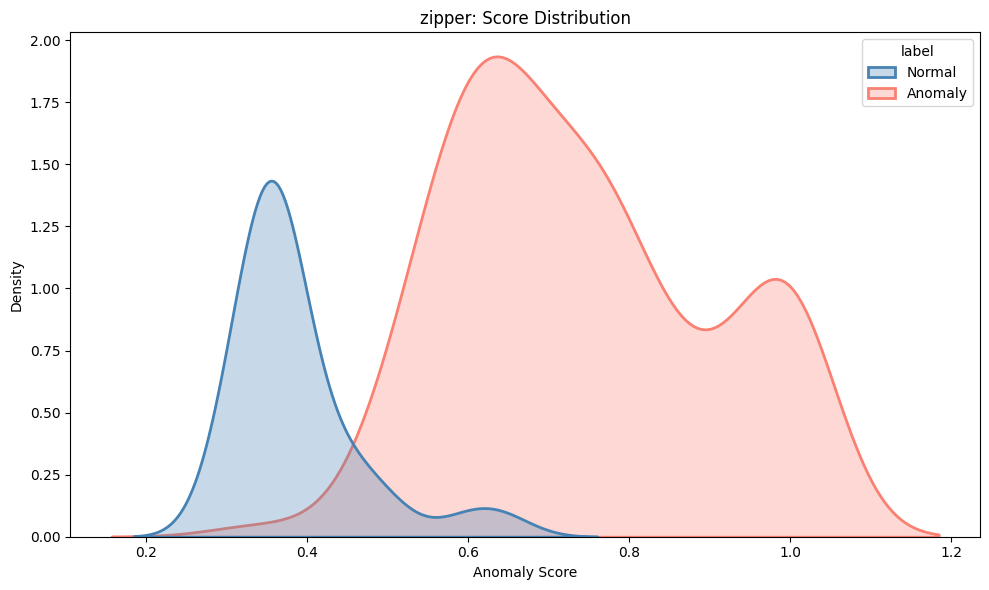

<Axes: title={'center': 'zipper: Score Distribution'}, xlabel='Anomaly Score', ylabel='Density'>

In [ ]:
from src.visual.plot import kde_plot

y_true_list = []
y_score_list = []

for p in predictions:
    gt = p.gt_label.cpu().numpy() if hasattr(p.gt_label, 'cpu') else p.gt_label
    score = p.pred_score.cpu().numpy() if hasattr(p.pred_score, 'cpu') else p.pred_score
    y_true_list.append(gt)
    y_score_list.append(score)

y_true = np.concatenate(y_true_list)
y_score = np.concatenate(y_score_list)

normal_scores = y_score[y_true == 0]
anomaly_scores = y_score[y_true == 1]

scores_df = pd.DataFrame({
    'score': np.concatenate([normal_scores, anomaly_scores]),
    'label': ['Normal'] * len(normal_scores) + ['Anomaly'] * len(anomaly_scores)
})

kde_plot(
    scores_df,
    col='score',
    hue='label',
    palette=['steelblue', 'salmon'],
    title=f'{category}: Score Distribution',
    xlabel='Anomaly Score'
)

In [ ]:
import torch
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    jaccard_score  # IoU
)

results = []
for category, preds in all_predictions.items():
    # Image-level
    y_true = np.concatenate([p.gt_label.cpu().numpy() for p in preds])
    y_score = np.concatenate([p.pred_score.cpu().numpy() for p in preds])
    y_pred = (y_score >= 0.5).astype(int)

    # Pixel-level
    gt_masks = torch.cat([p.gt_mask for p in preds]).int()
    pred_masks = torch.cat([(p.anomaly_map > 0.5).int() for p in preds])

    metrics = {
        "Category": category,
        "AUROC": round(roc_auc_score(y_true, y_score), 4),
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 4),
        "Dice": round(
            f1_score(
                gt_masks.flatten().cpu().numpy(),
                pred_masks.flatten().cpu().numpy(),
                zero_division=0
            ),
            4
        ),
        "IoU": round(
            jaccard_score(
                gt_masks.flatten().numpy(),
                pred_masks.flatten().numpy(),
                average='binary',
                zero_division=0
            ),
            4
        ),
        "N_samples": len(y_true)
    }
    results.append(metrics)

metrics_df = pd.DataFrame(results).set_index("Category")
avg_row = metrics_df.drop(columns=['N_samples']).mean().round(4)
avg_row['N_samples'] = metrics_df['N_samples'].sum()
metrics_df.loc['Average'] = avg_row

metrics_df

,AUROC,Accuracy,Precision,Recall,F1,Dice,IoU,N_samples
Category,,,,,,,,
bottle,1.0000,1.0000,1.0000,1.0000,1.0000,0.7263,0.5702,83.0
cable,0.9901,0.9667,0.9677,0.9783,0.9730,0.6393,0.4698,150.0
capsule,0.9924,0.9621,0.9727,0.9817,0.9772,0.5150,0.3468,132.0
carpet,0.9868,0.9658,0.9775,0.9775,0.9775,0.6069,0.4356,117.0
grid,0.9900,0.9615,0.9655,0.9825,0.9739,0.3871,0.2400,78.0
hazelnut,1.0000,1.0000,1.0000,1.0000,1.0000,0.6280,0.4578,110.0
leather,1.0000,1.0000,1.0000,1.0000,1.0000,0.4388,0.2811,124.0
metal_nut,0.9985,0.9913,1.0000,0.9892,0.9946,0.8406,0.7250,115.0
pill,0.9449,0.9222,0.9776,0.9291,0.9527,0.7199,0.5623,167.0


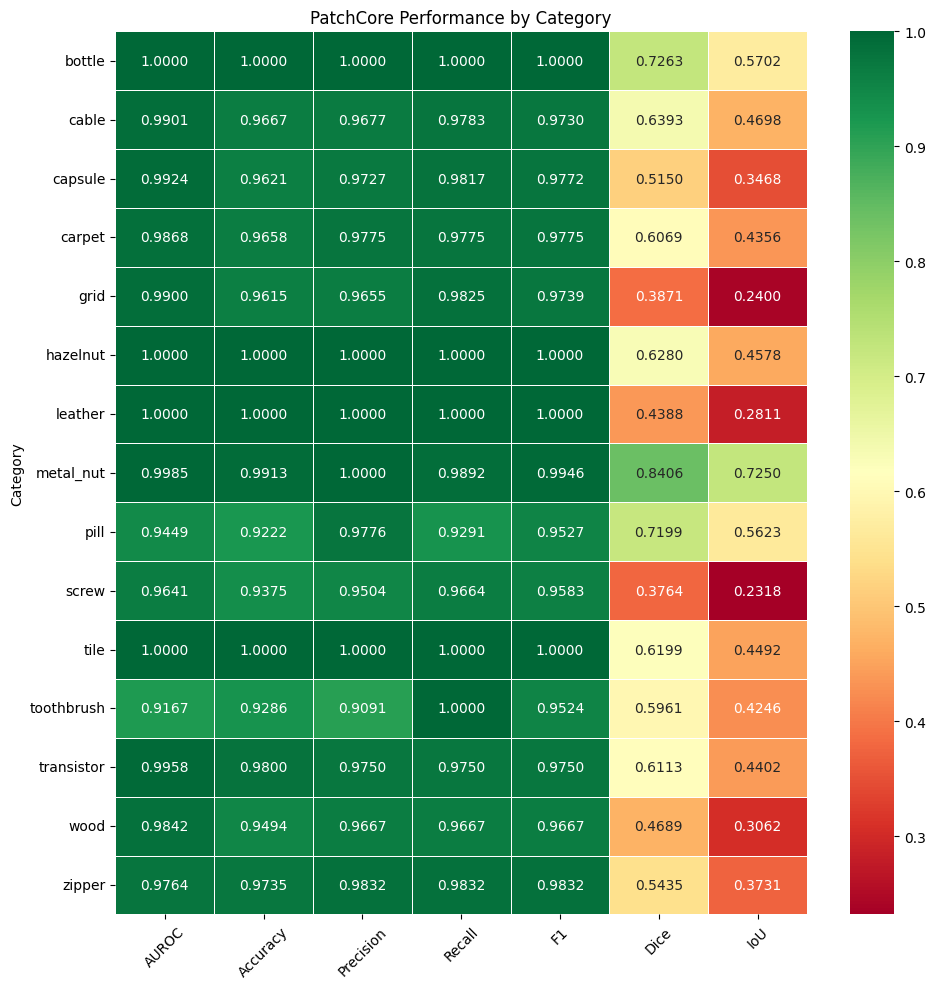

<Axes: title={'center': 'PatchCore Performance by Category'}, ylabel='Category'>

In [ ]:
from src.visual.plot import heatmap_plot

metrics_trans = metrics_df.drop('Average').drop(columns='N_samples')
heatmap_plot(
    metrics_trans,
    figsize=(10, 10),
    cmap='RdYlGn',
    annot=True,
    fmt='.4f',
    linewidths=0.5,
    title='PatchCore Performance by Category',
    rotation_x=45,
    rotation_y=0
)

bottle


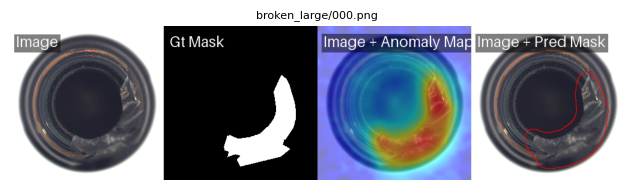

cable


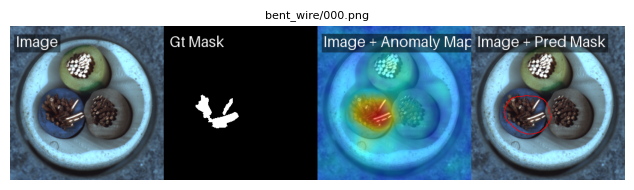

capsule


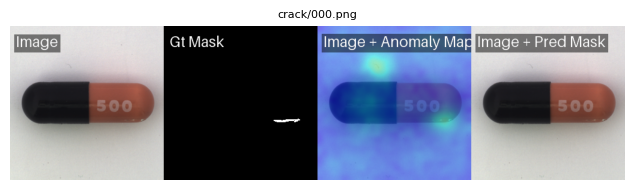

carpet


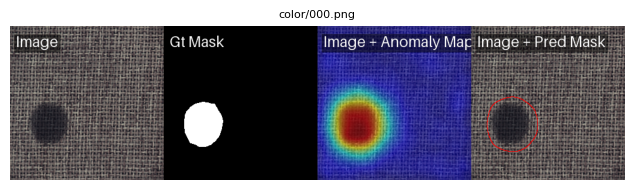

grid


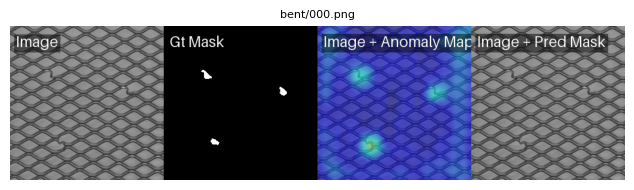

hazelnut


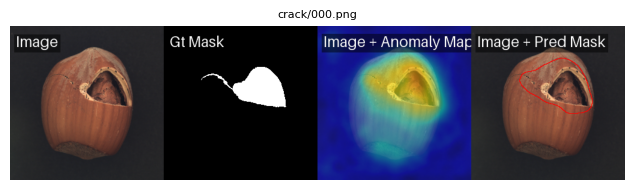

leather


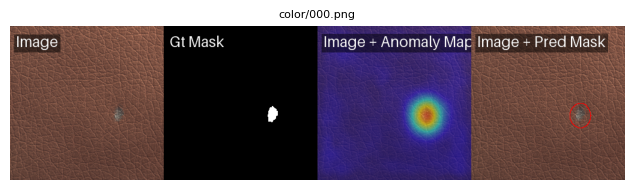

metal_nut


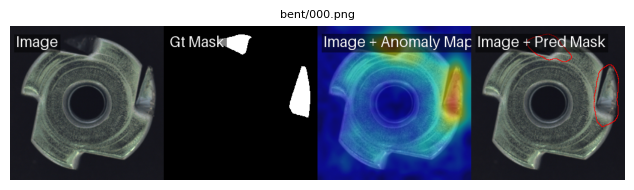

pill


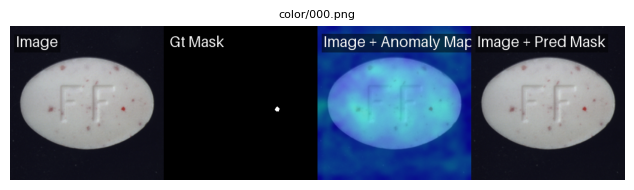

screw


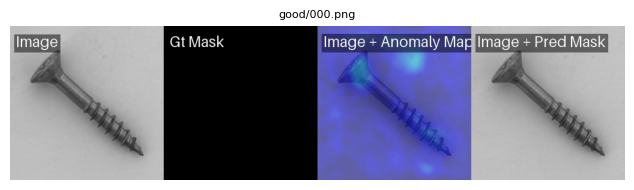

tile


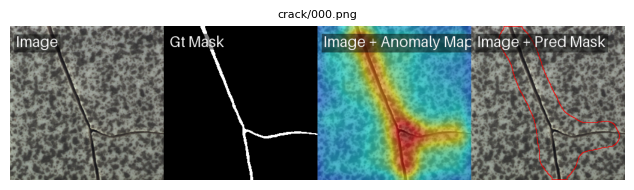

toothbrush


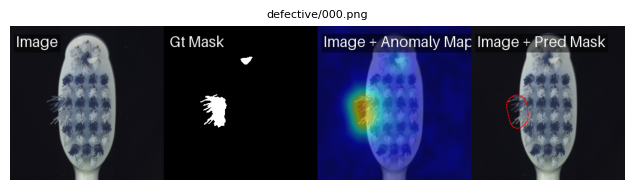

transistor


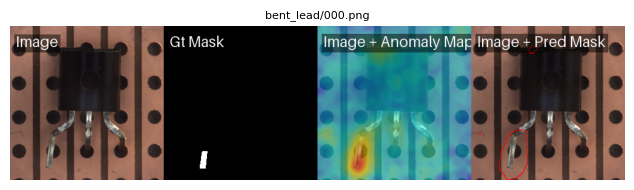

wood


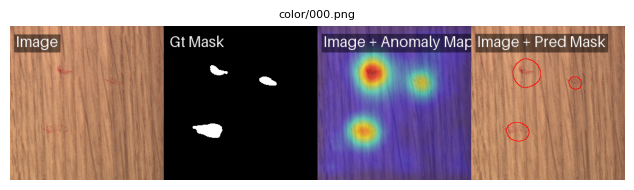

zipper


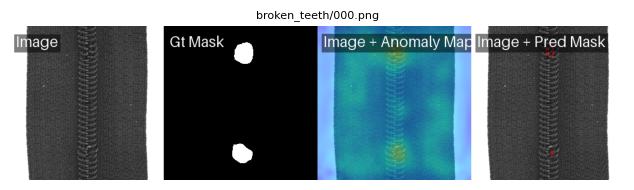

In [ ]:
from src.visual.plot import anomaly_grid_from_dir

for category in categories:
    OUTPUT_IMG_ROOT = OUTPUT_ROOT / "Patchcore" / "MVTecAD" / category / "latest" / "images"
    print(f"{category}")
    anomaly_grid_from_dir(OUTPUT_IMG_ROOT, n_samples=1, n_cols=1)